#### `Data information:`

- `100` genomes (strains) 
- `x3` different treatments (growth conditions)
- `x3` replicates
- plus 300 negative controls (referred to as "blanks")

In [1]:
import pandas as pd
import numpy as np
import glob
import os

# `Data analysis`

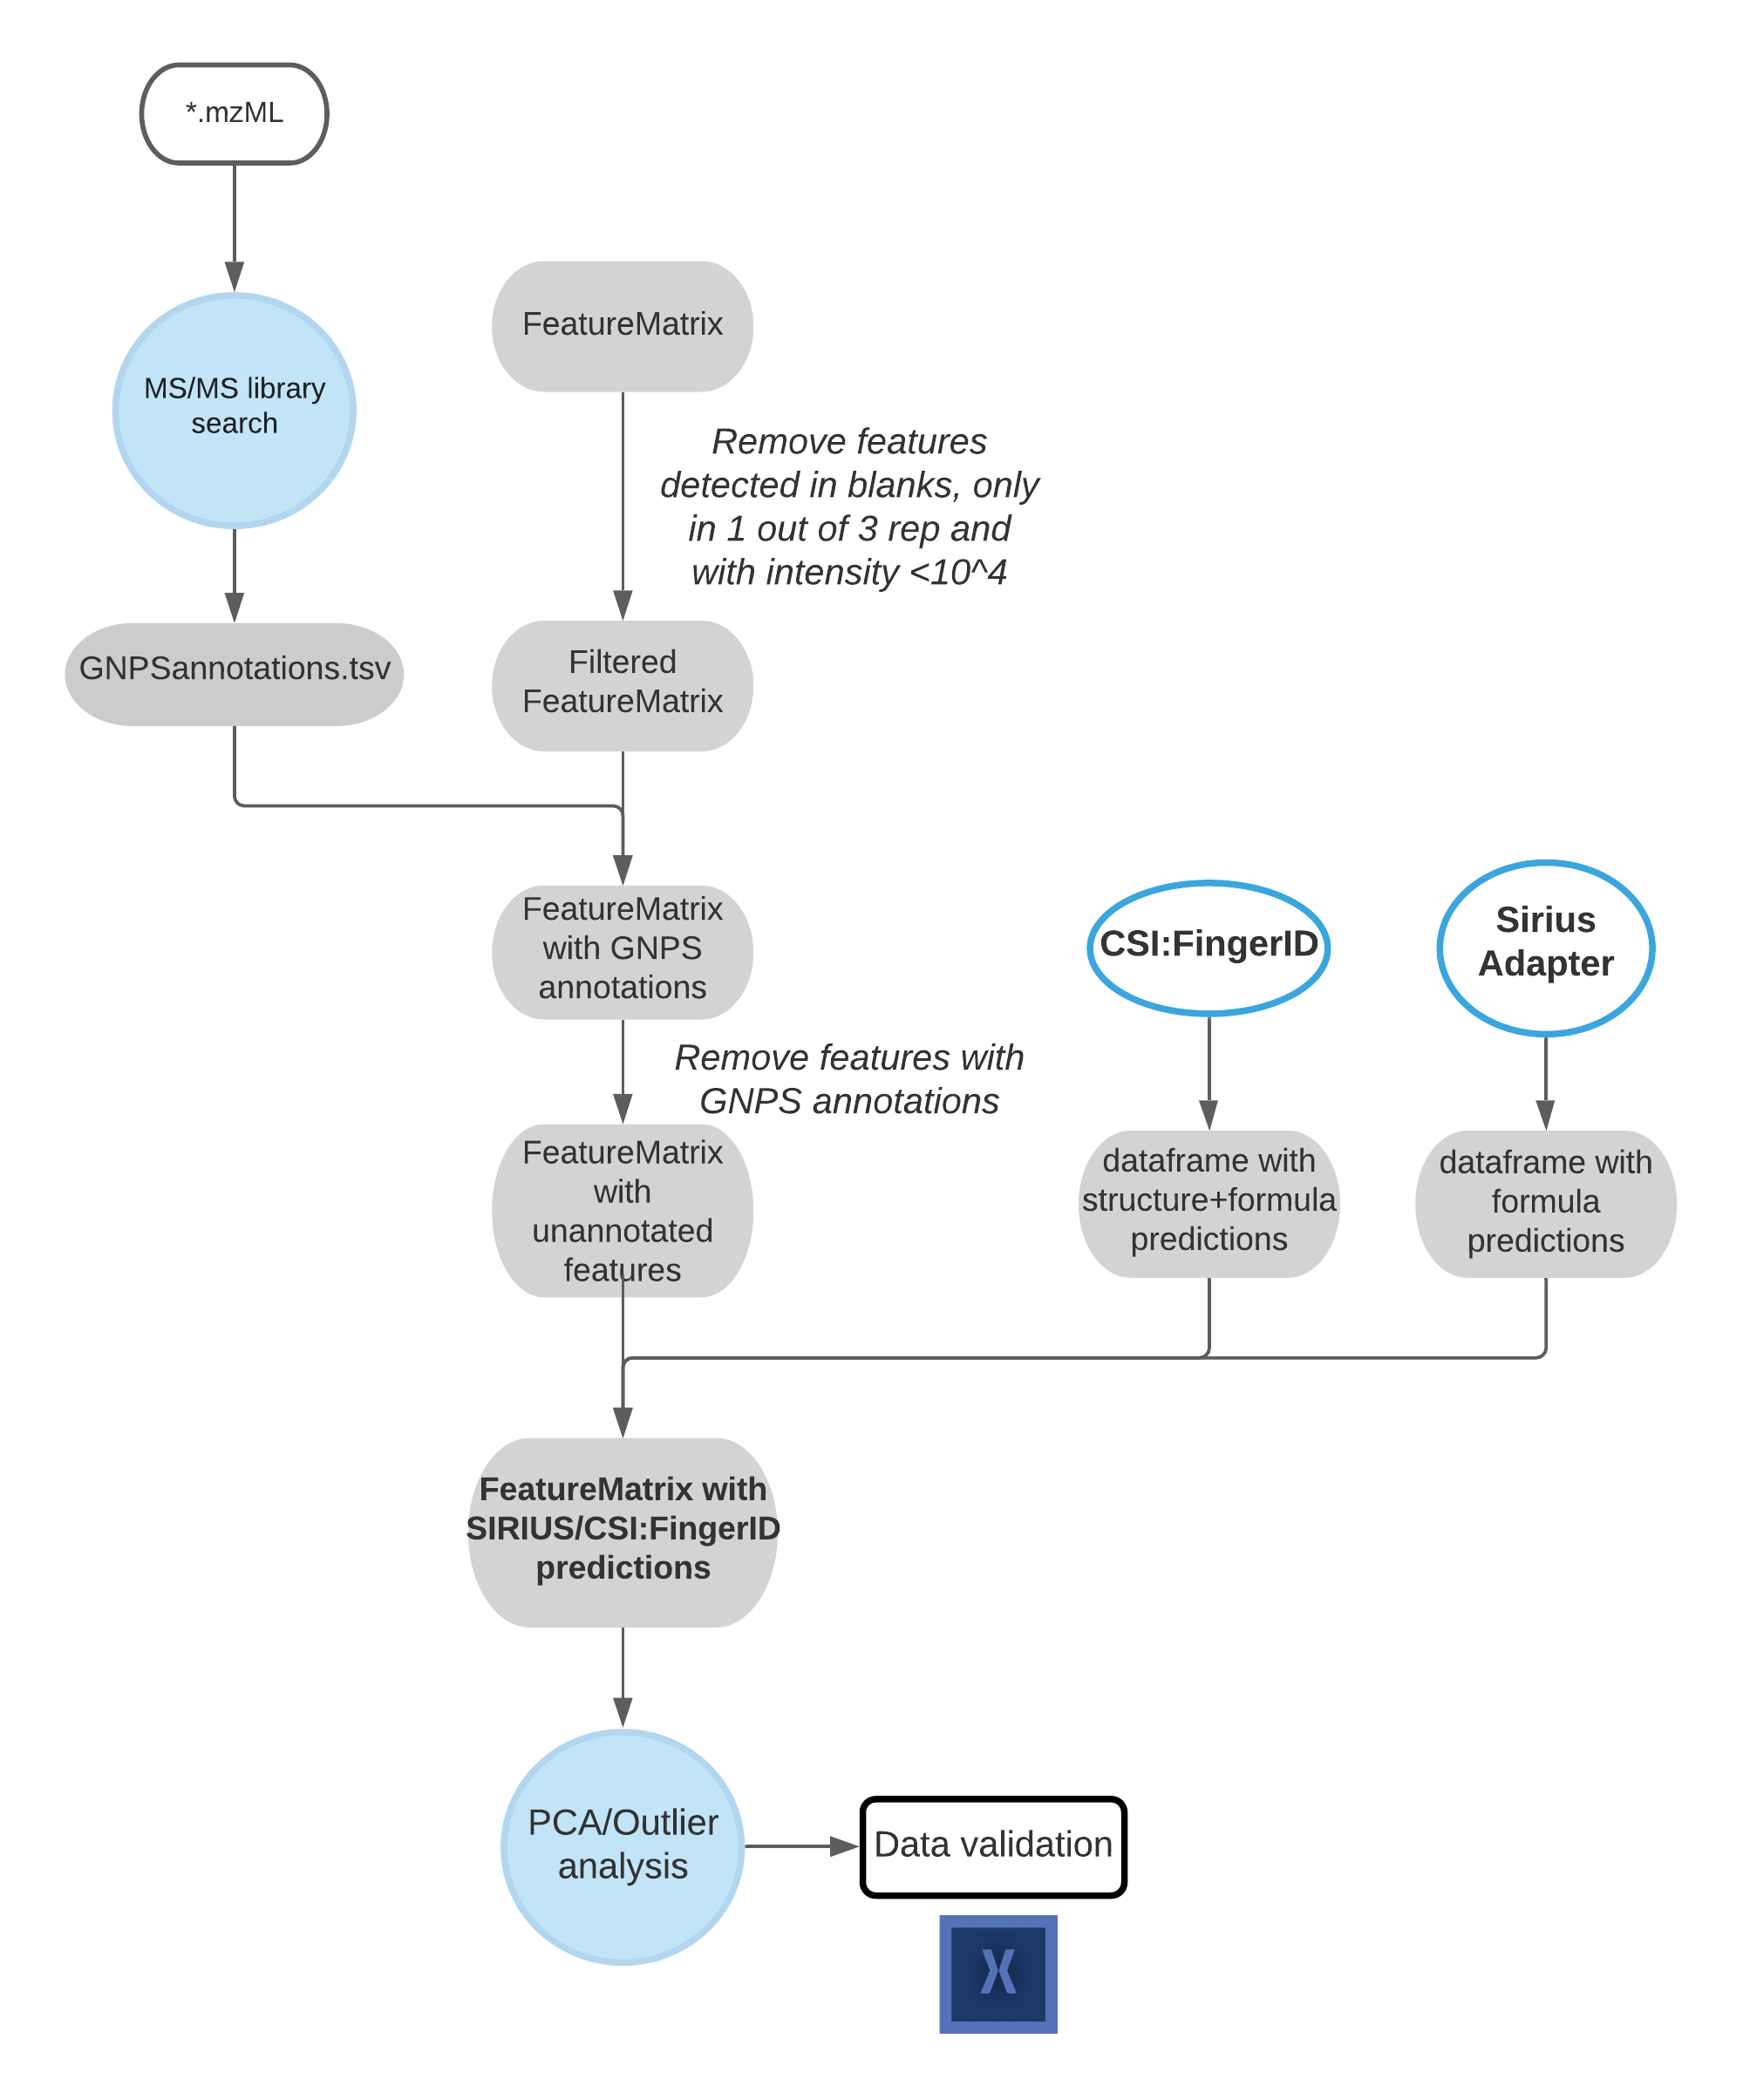

#### `1) Feature Matrix`
Import feature matrix and filter out as follows:
1) Drop the features detected in the negative controls (blanks)
2) Replace the presence of a feature with NaN if the feature is present in only 1 replicate

- Change the column names from maps to the original filename 

In [8]:
FeatureMatrix= "results/features/FeatureQuantificationTable.csv"
DF_features= pd.read_csv(FeatureMatrix, sep="\t")
DF_features=DF_features.set_index(["mz", "RT"])
DF_features

,,intensity,charge,quality_cf,20200429_sample_D_sw_pHILIC_yeast_B2017_0011_T1,20200429_sample_D_sw_pHILIC_yeast_B2017_0022_T1,20200429_sample_D_sw_pHILIC_yeast_B2017_0064_T1,20200429_sample_D_sw_pHILIC_yeast_B2018_0049_T1,20200429_sample_D_sw_pHILIC_yeast_B2018_0053_T1,20200429_sample_D_sw_pHILIC_yeast_B2018_0083_T1,20200429_sample_D_sw_pHILIC_yeast_B2019_0054_T1,20200429_sample_D_sw_pHILIC_yeast_B2019_0065_T1,20200429_sample_D_sw_pHILIC_yeast_B2019_0073_T1
mz,RT,,,,,,,,,,,,
714.506039,108.138810,5132343.0,1,0.000039,5168949.0,3975614.0,4278672.0,8977042.0,6754363.0,4654529.0,4740863.0,3957352.0,3683709.0
147.055850,24.384187,273925.3,1,0.000002,194441.1,190690.4,193444.9,192437.3,191970.2,446535.7,483171.7,236176.7,336459.9
130.086531,622.193143,66684070.0,1,0.000385,76872850.0,75356080.0,65977510.0,100119300.0,86662330.0,72332850.0,41369750.0,43240130.0,38225830.0
577.518777,108.239478,41796870.0,1,0.000307,54749900.0,47463970.0,38329630.0,53451800.0,36670460.0,38447350.0,43065680.0,30085490.0,33907560.0
766.557927,107.309399,29059470.0,1,0.000203,28710390.0,20097440.0,19189160.0,49137090.0,37771060.0,30709570.0,32823600.0,25539320.0,17557630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164.082661,262.052964,1228010.0,1,0.000009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1228010.0
538.338945,108.327072,1545041.0,2,0.000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1545041.0
150.051663,373.712442,232508.5,1,0.000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232508.5


`Split the Matrix according to the different media:`
1) Drop the features detected in more than 50% of the negative controls (blanks)*
###### *Drop the contaminated blanks first

In [4]:
path= "results/interim/analysis"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

In [5]:
media_list= [r"ISP2", r"FPY12", r"DNPM"] # 3 different media/conditions
for medium in media_list:
    Features_flt=DF_features.filter(regex=fr"{medium}")
    blanks= Features_flt.filter(regex="_blank", axis= 1) 
    contam_list =[r"MDNA_WGS_19", r"MDNA_WGS_25", r"NBC_01304", r"NBC_01250", r"NBC_01245", r"MDNA_WGS_5", r"NBC_00442", r"MDNA_WGS_86", r"NBC_00488", r"NBC_01103", r"NBC_01233", r"NBC_00168", r"MDNA_WGS_53", r"NBC_00990", r"NBC_01054", r"NBC_01127", r"NBC_01048", r"MDNA_WGS_68"] #(cross-)contaminated negative controls
    for contaminated in contam_list:
        contam_blanks= blanks.filter(regex=fr"{contaminated}")
        cols_contam= contam_blanks.columns
    blanks_no_contam= blanks.drop(columns=cols_contam)
    blanks_no_contam= blanks_no_contam.dropna(how="all")
    blanks_no_contam =blanks_no_contam.transpose()
    blanks_no_contam = blanks_no_contam.fillna(0)
    dictionary = {}
    cols= blanks_no_contam.columns
    for i, col in enumerate(cols):
        dictionary[i] = np.count_nonzero(blanks_no_contam[col]) / len(blanks_no_contam[col])
    column_idx = [key for key, value in dictionary.items() if value >= 0.5] #Remove features that appear most frequently (in more than 50% of the samples) in the negative controls
    blank_features= blanks_no_contam.iloc[:, column_idx] 
    cols= blank_features.columns
    Features_flt= Features_flt.transpose()
    Features_nb= Features_flt.drop(columns= cols)
    Features_nb= Features_nb.dropna(how="all")
    Features_nb= Features_nb.transpose()
    Features_nb= Features_nb.reset_index()
    blank_cols= blanks.columns
    Features_nb= Features_nb.drop(columns=blank_cols)
    filename= "results/interim/analysis/"+ medium + "_DF_features_no_blanks.csv"
    Features_nb.to_csv(filename, sep="\t")

2. Replace the features that have lower intensity than 10^4 with NaN (noise)

In [6]:
def noise_flt(csvfile):   
    Features= pd.read_csv(csvfile, sep="\t", index_col="Unnamed: 0")
    Features= Features.set_index(["mz", "RT"])
    Features= Features.sort_index(axis=1) 
    cols= Features.columns
    Features[cols] = Features[cols].replace({0:np.nan})
    Features[Features<10000] = np.nan
    Featuresnew=Features.dropna(how="all")
    Featuresnew = Featuresnew.fillna(0)
    DF= Featuresnew.reset_index()
    file_path = os.path.join(os.path.dirname(csvfile), 'int_flt_' + os.path.basename(csvfile))
    DF.to_csv(file_path, sep="\t")

In [7]:
csvfiles= glob.glob("results/interim/analysis/*no_blanks.csv")
for csvfile in csvfiles:
    noise_flt(csvfile)

3) Replace the presence of a feature with NaN if the feature is present in only 1 replicate

In [325]:
def rep_filter(csvfile):
    Features= pd.read_csv(csvfile, sep="\t", index_col="Unnamed: 0")
    Features= Features.set_index(["mz", "RT"])
    Features= Features.sort_index(axis=1)
    cols= Features.columns
    Features= Features.fillna(0)
    Features[Features!= 0] = 1 
    Features= Features.transpose()
    Features= Features.reset_index()
    print(Features)
    Features['genomeID']=Features['index'].str.extract(r'(NBC_?\d*)')
    Features['genomeID_MDNA']=Features['index'].str.extract(r'(MDNAWGS?\d*|MDNA_WGS_?\d*)')
    Features['genomeID']=Features['genomeID'].fillna(Features['genomeID_MDNA'])
    Features= Features.drop(columns=["genomeID_MDNA"])
    Features=Features.set_index(["index"])
    Grouped= Features.groupby("genomeID")
    DF= Grouped.transform(lambda x: np.nan if x.sum()<2 else x)
    DF=DF.transpose()
    DF=DF.reset_index()
    file_path = os.path.join(os.path.dirname(csvfile), 'rep_' + os.path.basename(csvfile))
    DF.to_csv(file_path, sep="\t")

In [ ]:
csvfiles= glob.glob("results/interim/analysis/int_flt_*.csv")
for csvfile in csvfiles:
    rep_filter(csvfile)

- Merge all tables on mz and RT:

In [327]:
Matrix_FPY12= pd.read_csv("results/interim/analysis/rep_int_flt_FPY12_DF_features_no_blanks.csv", sep="\t", index_col="Unnamed: 0")
Matrix_ISP2= pd.read_csv("results/interim/analysis/rep_int_flt_ISP2_DF_features_no_blanks.csv", sep="\t", index_col="Unnamed: 0")
Matrix_DNPM= pd.read_csv("results/interim/analysis/rep_int_flt_DNPM_DF_features_no_blanks.csv", sep="\t", index_col="Unnamed: 0")

Matrix_ISP2= Matrix_ISP2.set_index(["mz", "RT"])
Matrix_ISP2= Matrix_ISP2.fillna(0)
Matrix_ISP2= Matrix_ISP2.sort_index(axis=1)

Matrix_FPY12= Matrix_FPY12.set_index(["mz", "RT"])
Matrix_FPY12= Matrix_FPY12.sort_index(axis=1)
Matrix_FPY12= Matrix_FPY12.fillna(0)

Matrix_DNPM= Matrix_DNPM.set_index(["mz", "RT"])
Matrix_DNPM= Matrix_DNPM.fillna(0)
Matrix_DNPM= Matrix_DNPM.sort_index(axis=1)

In [328]:
Matrix_ISP2_FPY12= pd.merge(Matrix_FPY12, Matrix_ISP2, on=["mz", "RT"], how="outer")
Matrix= pd.merge(Matrix_ISP2_FPY12, Matrix_DNPM, on=["mz", "RT"],how= "outer")
cols= Matrix.columns
Matrix[cols] = Matrix[cols].replace({0:np.nan})
Matrix= Matrix.dropna(how="all")
Matrix

,,20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep1.mzML,20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep2.mzML,20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep3.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep2.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep3.mzML,20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep1.mzML,20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep2.mzML,20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep3.mzML
mz,RT,,,,,,,,,
185.092051,72.791274,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
466.306394,471.551350,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
287.171313,335.549298,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320.171802,98.844661,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
432.224079,308.467554,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
663.199189,233.122717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
614.278469,308.987685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
790.252446,336.081155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [329]:
Matrix= Matrix.reset_index()
Matrix.to_csv("results/interim/analysis/Matrix_no_blanks.csv", sep="\t")

- Cluster the different strains (groupby genome ID) and calculate the sum (0.0 no feature detected in all 3 treatments in all 3 replicates - 9.0 feature detected in all 3 treatments in all 3 replicates)

In [330]:
Matrix_IDs= Matrix.fillna(0)
Matrix_IDs= Matrix_IDs.set_index(["mz", "RT"])
Matrix_IDs= Matrix_IDs.sort_index(axis=1)
cols= Matrix_IDs.columns
Matrix_IDs= Matrix_IDs.transpose()
Matrix_IDs= Matrix_IDs.reset_index()
Matrix_IDs['genomeID']=Matrix_IDs['index'].str.extract(r'(NBC_?\d*)')
Matrix_IDs['genomeID_MDNA']=Matrix_IDs['index'].str.extract(r'(MDNAWGS?\d*|MDNA_WGS_?\d*)')
Matrix_IDs['genomeID']=Matrix_IDs['genomeID'].fillna(Matrix_IDs['genomeID_MDNA'])
Matrix_IDs= Matrix_IDs.drop(columns=["genomeID_MDNA"])
Matrix_IDs=Matrix_IDs.set_index(["index"])
Grouped= Matrix_IDs.groupby("genomeID").sum()
Grouped= Grouped.transpose()
Grouped= Grouped.reset_index()
Grouped.to_csv("results/interim/analysis/Grouped_Matrix.csv", sep="\t")
Grouped= Grouped.set_index(["mz", "RT"])
Grouped

/Users/eeko/opt/anaconda3/envs/pyopenms/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,genomeID,MDNAWGS11
mz,RT,
185.092051,72.791274,3.0
466.306394,471.551350,3.0
287.171313,335.549298,2.0
320.171802,98.844661,3.0
432.224079,308.467554,6.0
...,...,...
663.199189,233.122717,2.0
614.278469,308.987685,2.0
790.252446,336.081155,2.0


#### `2) GNPS`
Import all identifications from GNPS (from 100 files or so) and "clean up" the table

In [331]:
df= pd.read_csv("./resources/MS2_LIBRARYSEARCH_all_identifications.tsv", sep='\t', encoding='latin-1')
df.drop(df.index[df['IonMode'] == "negative"], inplace=True)
df.drop(df.index[df['MZErrorPPM'] > 20.0], inplace=True)
GNPS=df.filter(["Compound_Name", "RT_Query", "Precursor_MZ"])
GNPS=GNPS.rename(columns= {"RT_Query": "RetentionTime"})
GNPS=GNPS.drop_duplicates(subset="Compound_Name", keep='first')
GNPS

,Compound_Name,RetentionTime,Precursor_MZ
0,dehydroxynocardamine,347.70300,585.361000
2,Massbank:PR311142 Cyclo(leucylprolyl),200.44700,211.144000
6,cyclo(L-Val-L-Pro),311.23700,197.129000
8,"""(4R)-4-((3R,5R,6S,7R,9S,10R,12S,13R,17R)-3,6,...",419.38900,871.554000
9,Massbank:PR300821 Cyclo(proline-leucine),223.96100,211.144000
...,...,...,...
356761,Spectral Match to Tyr-Ala from NIST14,76.97570,253.118000
357126,epemicinA,412.72450,793.446100
357127,epemicinB,405.53937,712.420400
357128,"epemicinB, M+H",405.53937,1423.832300


Annotate the features detected by GNPS according to mz and RT (mz tolerance 10 ppm and RT tolerance 20 seconds)

In [332]:
FeatureMatrix= pd.read_csv("results/interim/analysis/Grouped_Matrix.csv", sep='\t', index_col="Unnamed: 0")
FeatureMatrix

,mz,RT,MDNAWGS11
0,185.092051,72.791274,3.0
1,466.306394,471.551350,3.0
2,287.171313,335.549298,2.0
3,320.171802,98.844661,3.0
4,432.224079,308.467554,6.0
...,...,...,...
2108,663.199189,233.122717,2.0
2109,614.278469,308.987685,2.0
2110,790.252446,336.081155,2.0
2111,612.608923,409.370202,2.0


In [333]:
FeatureMatrix.insert(0, 'GNPS_IDs', '')

for i, mz, rt in zip(FeatureMatrix.index, FeatureMatrix['mz'], FeatureMatrix['RT']):
    hits = []
    for name, GNPS_mz, GNPS_rt, in zip(GNPS['Compound_Name'], GNPS['Precursor_MZ'], GNPS['RetentionTime']):
        mass_delta = (abs(GNPS_mz-mz)/GNPS_mz)*1000000.0 if GNPS_mz != 0 else np.nan
        if (GNPS_rt >= rt-30.0) & (GNPS_rt <= rt+30.0) & (mass_delta<= 20.0):
            hit = f'{name}'
            if hit not in hits:
                hits.append(hit)
    FeatureMatrix['GNPS_IDs'][i] = ' ## '.join(hits)

FeatureMatrix.to_csv("results/data_analysis/GNPS_annotated_feature_matrix.tsv", sep='\t', index = False)
FeatureMatrix

/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_6376/2891053151.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FeatureMatrix['GNPS_IDs'][i] = ' ## '.join(hits)


,GNPS_IDs,mz,RT,MDNAWGS11
0,cyclo-(Ala-4-hydroxy-Pro),185.092051,72.791274,3.0
1,,466.306394,471.551350,3.0
2,,287.171313,335.549298,2.0
3,,320.171802,98.844661,3.0
4,,432.224079,308.467554,6.0
...,...,...,...,...
2108,,663.199189,233.122717,2.0
2109,Ferrioxamine B [M+Fe-2H] ## Ferrioxamine B (M-...,614.278469,308.987685,2.0
2110,,790.252446,336.081155,2.0
2111,,612.608923,409.370202,2.0


Keep the unannotated features only

In [334]:
FeatureMatrix= FeatureMatrix[FeatureMatrix.GNPS_IDs == '']
FeatureMatrix= FeatureMatrix.drop(columns= "GNPS_IDs")
FeatureMatrix= FeatureMatrix.set_index(["RT", "mz"])
FeatureMatrix_tocsv= FeatureMatrix.reset_index()
FeatureMatrix_tocsv.to_csv("results/data_analysis/FeatureMatrix_unknowns.tsv", sep="\t", index =None)
FeatureMatrix

,,MDNAWGS11
RT,mz,
471.551350,466.306394,3.0
335.549298,287.171313,2.0
98.844661,320.171802,3.0
308.467554,432.224079,6.0
455.107397,353.222295,2.0
...,...,...
327.132509,1106.471651,2.0
233.122717,663.199189,2.0
336.081155,790.252446,2.0


#### `4) SIRIUS and CSI:FingerID annotations`

Create a matrix with all SIRIUS and CSI:FingerID formula and structural predictions, only choose #1 rankings predictions and combine the dataframes to annotate formula and structural predictions according to RT and mz:

In [335]:
import glob
import pandas as pd
import numpy as np

input_formulas = glob.glob("results/formulas/formulas_*.csv")
input_structures = glob.glob("results/structures/structures_*.csv")

df_formulas will contain likely duplicate formulas that could be either isomeric, isobaric compounds, or identical compounds (with identical RT and mz)

In [ ]:
DF_SIRIUS=[]
for csv in input_formulas:
    df= pd.read_csv(csv, sep=",")
    df= df.loc[df["opt_global_rank"]==1]
    df_score=df.filter(regex=fr"Score")
    df_opt=df.filter(regex=fr"opt")
    cols_score= df_score.columns
    cols_opt= df_opt.columns
    df= df.drop(columns=cols_score)
    df= df.drop(columns= cols_opt)
    df=df.reset_index()
    DF_SIRIUS.append(df)

DF_SIRIUS=pd.concat(DF_SIRIUS, axis=0)
DF_SIRIUS= df.drop(columns="index")
df_formulas= DF_SIRIUS.rename(columns= {"chemical_formula": "formulas", "exp_mass_to_charge": "mz", "retention_time": "RT"})
df_formulas_helper= df_formulas.copy(deep=True)
df_formulas= df_formulas.set_index("formulas")
df_singletons=df_formulas.reset_index().drop_duplicates(subset="formulas", keep=False)
df_singletons= df_singletons.set_index("formulas")
idx= df_singletons.index
df_sirius= df_formulas.drop(labels=idx, axis=0)
new_df= pd.DataFrame()
df= pd.DataFrame()
idx= df_sirius.index
for i, index in enumerate(idx):
    new_index= new_df.index
    if index not in new_index:
        s= df_sirius.iloc[i]
        new_df= new_df.append(s)
    else:
        #print(index)
        mz_0= df_sirius["mz"][i]
        mz_1= new_df["mz"][index]
        time_0= df_sirius["RT"][i]
        time_1= new_df["RT"][index]
        #(print(mz_0, time_0, mz_1, time_1))
        mass_delta = (abs(mz_0 - mz_1)/mz_0)*1000000
        maxdeltaRT = time_0 + 30.0
        mindeltaRT = time_0 - 30.0
        if (mindeltaRT<= time_1 <= maxdeltaRT) & (mass_delta<= 20.0):
            pass
        else:
            m= df_sirius.iloc[i]
            df= df.append(m)


DF_SIRIUS= pd.concat([new_df, df], axis=0)
DF_SIRIUS_final= pd.concat([DF_SIRIUS, df_singletons], axis=0)
DF_SIRIUS_final= DF_SIRIUS_final.reset_index()
DF_SIRIUS_final= DF_SIRIUS_final.rename(columns={"index":"formulas"})
DF_SIRIUS_final

Repeat for structral predictions (remove duplicates with the same inchi_keys, which means they represent the same structure):

In [ ]:
CSI=[]
for csv in input_structures:
    df= pd.read_csv(csv, sep=",", index_col="Unnamed: 0")
    df_rank= df.filter(regex=fr"opt_global_rank")
    df_score=df.filter(regex=fr"best_search_engine_score")
    df_opt=df.filter(regex=fr"opt")
    cols_score= df_score.columns
    cols_opt= df_opt.columns
    df= df.dropna()
    df= df.drop(columns=cols_score)
    df= df.drop(columns= cols_opt)
    df= df.drop(columns= "identifier")
    df=df.reset_index()
    df= df.drop(columns="index")
    CSI.append(df)

DF_CSI=pd.concat(CSI, axis=0)

df_structures = DF_CSI.drop_duplicates(subset=['inchi_key'], keep='first')
df_structures= df_structures.drop(columns=["inchi_key"]) #leave smiles for visualisationdf_structures= df_structures.rename(columns={"chemical_formula": "formulas", "exp_mass_to_charge": "mz", "retention_time": "RT"})
df_structures= df_structures.rename(columns={"chemical_formula":"formulas"})
df_structures_helper= df_structures.copy(deep=True)
df_structures= df_structures.set_index("formulas")
df_singletons=df_structures.reset_index().drop_duplicates(subset="formulas", keep=False)
df_singletons= df_singletons.set_index("formulas")
idx= df_singletons.index
df_CSI= df_structures.drop(labels=idx, axis=0)
new_df= pd.DataFrame()
df= pd.DataFrame()
idx= df_CSI.index
for i, index in enumerate(idx):
    new_index= new_df.index
    if index not in new_index:
        s= df_CSI.iloc[i]
        new_df= new_df.append(s)
    else:
        #print(index)
        mz_0= df_CSI["exp_mass_to_charge"][i]
        mz_1= new_df["exp_mass_to_charge"][index]
        time_0= df_CSI["retention_time"][i]
        time_1= new_df["retention_time"][index]
        #(print(mz_0, time_0, mz_1, time_1))
        mass_delta = (abs(mz_0 - mz_1)/mz_0)*1000000
        maxdeltaRT = time_0 + 30.0
        mindeltaRT = time_0 - 30.0
        if (mindeltaRT<= time_1 <= maxdeltaRT) & (mass_delta<= 20.0):
            pass
        else:
            m= df_CSI.iloc[i]
            df= df.append(m)


DF_CSI= pd.concat([new_df, df], axis=0)
DF_CSI_final= pd.concat([DF_CSI, df_singletons], axis=0)
DF_CSI_final= DF_CSI_final.reset_index()
DF_CSI_final= DF_CSI_final.rename(columns={"index":"formulas"})
DF_CSI_final

,smiles,description,exp_mass_to_charge,retention_time
formulas,,,,
C21H30N2O7,COC1=CC=C(C=C1)C2(CCOCC2)CNC(=O)NC(CCC(=O)OC)C...,dimethyl (2S)-2-[[4-(4-methoxyphenyl)oxan-4-yl...,423.212852,307.765093
C17H26N8O5,C1=NC2=C(C(=O)N1)N=CN2CCCCCOC(=O)NC(CCCN=C(N)N...,N(2)-(5-(Hypoxanthin-9-yl)pentyloxycarbonyl)ar...,423.212852,307.765093
C16H31N5O6,C(CCN)CC(C(=O)NC(CC(=O)O)C(=O)NC(CCCCN)C(=O)O)N,"(2S)-6-amino-2-[[(2S)-2-[[(2S)-2,6-diaminohexa...",412.219263,62.368338
C24H30O14,CC1C(C(C(C(O1)OCC2C(C(C(C(O2)OC3=C(C=C4C=CC(=O...,"4,5-dihydroxy-2-methyl-6-{[3,4,5-trihydroxy-6-...",565.155595,275.013266
C21H28O12,C1=CC=C(C=C1)C=CC(=O)OCC2C(C(C(C(O2)OC3(C(C(C(...,"[(2R,3S,4S,5R,6R)-6-[(2S,3S,4S,5R)-3,4-dihydro...",490.192150,108.148371
...,...,...,...,...
C22H32N4O4S,CCCOC1=C(C=C(C=C1)S(=O)(=O)N2CCN(CC2)C)C3=NC(=...,"5,6-Diethyl-2-{5-[(4-Methylpiperazin-1-Yl)sulf...",449.224470,130.208793
C53H78N8O10,CC1CC2C(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)N(C(C(=O)...,"N-[(3S,6S,9S,10R,13S,16S,19S,22S,25S,27R)-19-b...",987.589352,437.846465
C51H86O18,CC1CC(C(OC1C2CC(C(O2)C3(CCC(O3)C4(CCC5(O4)CC(C...,"Semduramicin, 5-O-(tetrahydro-5-hydroxy-6-meth...",987.589352,437.846465


Annotate the formulas and structural predictions to the feature matrix according to SIRIUS and CSI:

In [337]:
DF_features= pd.read_csv("results/interim/analysis/Matrix_no_blanks.csv", sep="\t", index_col="Unnamed: 0")
DF_features

,mz,RT,20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep1.mzML,20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep2.mzML,20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep3.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep2.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep3.mzML,20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep1.mzML,20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep2.mzML,20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep3.mzML
0,185.092051,72.791274,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,466.306394,471.551350,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,287.171313,335.549298,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,320.171802,98.844661,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,432.224079,308.467554,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2108,663.199189,233.122717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2109,614.278469,308.987685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2110,790.252446,336.081155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2111,612.608923,409.370202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [ ]:
DF_features.insert(0, 'CSI_predictions_name', '')
DF_features.insert(0, 'CSI_predictions_formula', '')
DF_features.insert(0, 'CSI_predictions_smiles', '')


for i, mz, rt in zip(DF_features.index, DF_features['mz'], DF_features['RT']):
    hits1 = []
    hits2= []
    hits3=[]
    for name, smiles, formula, Pred_mz, Pred_rt, in zip(DF_CSI_final['description'], DF_CSI_final['smiles'], DF_CSI_final['formulas'], DF_CSI_final['exp_mass_to_charge'], DF_CSI_final['retention_time']):
        mass_delta = (abs(Pred_mz-mz)/Pred_mz)*1000000.0 if Pred_mz != 0 else 0
        if (Pred_rt >= rt-30.0) & (Pred_rt <= rt+30.0) & (mass_delta<= 20.0):
            hit1 = f'{name}'
            hit2 = f'{formula}'
            hit3= f'{smiles}'
            if hit1 not in hits1:
                hits1.append(hit1)
                hits2.append(hit2)
                hits3.append(hit3)
    DF_features['CSI_predictions_name'][i] = ' ## '.join(hits1)
    DF_features['CSI_predictions_formula'][i] = ' ## '.join(hits2)
    DF_features['CSI_predictions_smiles'][i] = ' ## '.join(hits3)
DF_features

/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_6376/909905963.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_features['CSI_predictions_name'][i] = ' ## '.join(hits1)
/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_6376/909905963.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_features['CSI_predictions_formula'][i] = ' ## '.join(hits2)
/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_6376/909905963.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

,CSI_predictions_smiles,CSI_predictions_formula,CSI_predictions_name,mz,RT,20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep1.mzML,20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep2.mzML,20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep3.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep2.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep3.mzML,20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep1.mzML,20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep2.mzML,20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep3.mzML
0,,,,185.092051,72.791274,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,,,466.306394,471.551350,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,,,,287.171313,335.549298,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C1=CC(=CC=C1CC2C(=O)NC(C(=O)N2)CCCN=C(N)N)O,C15H21N5O3,Cyclo(tyr-arg),320.171802,98.844661,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,,,,432.224079,308.467554,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,,,,663.199189,233.122717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2109,,,,614.278469,308.987685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2110,,,,790.252446,336.081155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2111,,,,612.608923,409.370202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [ ]:
DF_features.insert(0, 'SIRIUS_predictions', '')

for i, mz, rt in zip(DF_features.index, DF_features['mz'], DF_features['RT']):
    hits = []
    for name, Pred_mz, Pred_rt, in zip(DF_SIRIUS_final['formulas'], DF_SIRIUS_final['mz'], DF_SIRIUS_final['RT']):
        mass_delta = (abs(Pred_mz-mz)/Pred_mz)*1000000.0 if Pred_mz != 0 else 0
        if (Pred_rt >= rt-30.0) & (Pred_rt <= rt+30.0) & (mass_delta<= 20.0):
            hit = f'{name}'
            if hit not in hits:
                hits.append(hit)
    DF_features['SIRIUS_predictions'][i] = ' ## '.join(hits)
DF_features

/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_6376/1634366985.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_features['SIRIUS_predictions'][i] = ' ## '.join(hits)


,SIRIUS_predictions,CSI_predictions_smiles,CSI_predictions_formula,CSI_predictions_name,mz,RT,20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep1.mzML,20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep2.mzML,20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep3.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep2.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep3.mzML,20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep1.mzML,20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep2.mzML,20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep3.mzML
0,C8H9NO3,,,,185.092051,72.791274,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,,,,466.306394,471.551350,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,,,,,287.171313,335.549298,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C15H21N5O3 ## C15H18N4O3,C1=CC(=CC=C1CC2C(=O)NC(C(=O)N2)CCCN=C(N)N)O,C15H21N5O3,Cyclo(tyr-arg),320.171802,98.844661,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,,,,,432.224079,308.467554,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2108,,,,,663.199189,233.122717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2109,,,,,614.278469,308.987685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2110,,,,,790.252446,336.081155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2111,,,,,612.608923,409.370202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [ ]:
DF_features.to_csv("results/data_analysis/FeatureMatrix_SIRIUS_CSI.csv", sep="\t", index= None)

#### `5) PCA and outlier analysis`

##### `(i) Data pre-treatment`

In [338]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc 

from collections import Counter
#from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from sklearn.model_delection import ParameterGrid
from sklearn.datasets import load_iris
from sklearn import metrics

In [339]:
Matrix= pd.read_csv("results/data_analysis/Grouped_Matrix.csv", sep="\t", index_col= "Unnamed: 0")
Matrix= Matrix.set_index(["mz", "RT"])
Matrix= Matrix.transpose()
Matrix

mz,185.092051,466.306394,287.171313,320.171802,432.224079,353.222295,348.232082,409.162123,393.223162,414.234744,...,647.250126,539.249962,881.351907,554.260773,1106.471651,663.199189,614.278469,790.252446,612.608923,994.370290
RT,72.791274,471.551350,335.549298,98.844661,308.467554,455.107397,600.372797,496.388420,286.809572,209.283068,...,60.104045,348.083089,327.132509,224.211652,327.132509,233.122717,308.987685,336.081155,409.370202,304.568949
MDNAWGS11,3.0,3.0,2.0,3.0,6.0,2.0,3.0,2.0,5.0,3.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


- `Centering`
    - Import the grouped csv files and perform mean centering to focus on the fluctuating part of the data  

In [ ]:
Matrix_centered = Matrix.apply(lambda x: x-x.mean())
Matrix_centered

- Explore if you have outliers with unbiasted skew

In [ ]:
Matrix_centered.skew(axis=0, skipna = True)

In [ ]:
Matrix_centered.describe()

- `Standardization`
    - This will make sure that all the features are centred around the mean value with a standard deviation value of 1. This is the best to use if your feature is normally distributed.

In [ ]:
import math
def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)


def stdev(data):
    var = variance(data)
    std_dev = math.sqrt(var)
    return std_dev
    
Matrix_standardized= Matrix_centered.apply(lambda x: (x-x.mean()) / stdev(x))
Matrix_standardized

In [ ]:
x= Matrix_centered
scaled_data = Matrix_max_scaled
f, ax = plt.subplots(1,2)
sns.distplot(x, ax=ax[0], color='y')
ax[0].set_title("Original data")
sns.distplot(scaled_data, ax=ax[1], color='g')
ax[1].set_title("Scaled data")
plt.show()

In [ ]:
# So, as you know, the principle components of the data are the
# dimensions along which the data varies the most. The data
# here is 4 dimensional (since there are 4 features) and thus
# there are 4 total principle components.

# The first principle component will be the line along which the
# data varies the most. The second will be the line along with the
# data varies the second monst, and so on. The sum of the variances
# of all the principle components will be the entire variance of the
# dataset.

# Okay, so let's use the PCA function to get all 4 principle components.

# As always with the sklearn package, we first have to create and save
# a function "object":
pca = PCA(n_components=4)

# We can actually use this function object to get the first 4 principle
# components of any data. Let's do it for our data:
data_pca = pca.fit_transform(df)

# Now that we've called fit_transform, the pca object some attributes
# that includes the data points transformed along the principle components.
# So let's plot the data points along the first two principle components.
# We'll use the matplotlib.pyplot package to do this:
plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Our data along the first two PCs")
plt.grid(True)
plt.show()

# The explained variance is also included in the pca object.
# So we can plot that as well:
plt.plot(pca.explained_variance_ratio_,
        label="Percent of variance explained for each PC")
plt.plot([sum(pca.explained_variance_ratio_[:i]) for i in range(1, 5)],
        label="Cumulative percent of variance explained")
plt.legend()
plt.grid(True)
plt.xticks(range(4), ["%0.0f" % i for i in range(1, 5)])
plt.ylabel("%")
plt.xlabel("PC")
plt.title("Variance explained by each PC")
plt.show()

#make a plot where you zoom in
#volcano plots
# So now we see empirical evidence that the sum of all 4 variances
# equals the total variance in the data set (shown by the orange line) :)

In [ ]:
from pca import pca

# Initialize to reduce the data up to the number of componentes that explains 95% of the variance.
model = pca(n_components=0.95)

# Or reduce the data towards 2 PCs
model = pca(n_components=2)

# Fit transform
results = model.fit_transform(Matrix_standardized)

# Plot explained variance
fig, ax = model.plot()

# Scatter first 2 PCs
fig, ax = model.scatter()

# Make biplot with the number of features
fig, ax = model.biplot(n_feat=4)

Interactive PCA plots inspired from https://www.kaggle.com/maniyar2jaimin/interactive-plotly-guide-to-pca-lda-t-sne

In [ ]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls

import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [ ]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
X = df.values
X_std = StandardScaler().fit_transform(X)
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eigh(cov_mat) #ASK
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

In [ ]:
trace1 = go.Scatter(
    x=list(range(10)),
    y= cum_var_exp,
    mode='lines+markers',
    hoverinfo= "all",
    name="'Cumulative Explained Variance'",
    line=dict(
        shape='spline',
        color = 'goldenrod'
    )
)
trace2 = go.Scatter(
    x=list(range(10)),
    y= var_exp,
    hoverinfo= "all",
    mode='lines+markers',
    name="'Individual Explained Variance'",
    line=dict(
        shape='linear',
        color = 'black'
    )
)
fig = tls.make_subplots(insets=[{'cell': (1,1), 'l': 0.7, 'b': 0.3}],
                          print_grid=True)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2,1,1)
fig.layout.xaxis = dict(range=[0, 9.5])
fig.layout.yaxis = dict(range=[0, 110])

py.iplot(fig, filename='inset example')

This is the format of your plot grid:
[ (1,1) x,y ]

With insets:
[ x2,y2 ] over [ (1,1) x,y ]



In [ ]:
X= df.values

# Standardising the values
X_std = StandardScaler().fit_transform(X)

# Call the PCA method with 50 components. 
pca = PCA(n_components=5)
pca.fit(X_std)
X_5d = pca.transform(X_std)

# For cluster coloring in our Plotly plots, remember to also restrict the target values 
Target = target

In [ ]:
trace0 = go.Scatter(
    x = X_5d[:,0],
    y = X_5d[:,1],
    name = "Target",
    hoverinfo = 'all',
    mode = 'markers',
#     text = Target.unique(),
    showlegend = False,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [trace0]

layout = dict(title = 'PCA (Principal Component Analysis)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= True
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

In [ ]:
Q1=Matrix_standardized.quantile(0.25)
Q3=Matrix_standardized.quantile(0.75)
IQR=Q3-Q1
upper_val= Q3+1.5*IQR
lower_val= Q1-1.5*IQR 

In [ ]:
lower_val.to_csv("lower_val_atratus.csv", sep="\t")
lower_val

In [ ]:
upper_val.to_csv("upper_val_atratus.csv", sep="\t")
upper_val

In [ ]:
Matrix_standardized= Matrix_standardized.transpose()
Matrix_standardized= Matrix_standardized.reset_index()
Matrix_standardized

In [ ]:
upper_val= pd.read_csv("upper_val", sep="\t")
Matrix_scaled= pd.merge(Matrix_standardized, upper_val, on="Feature_ID")
Matrix_scaled= Matrix_scaled.set_index("Feature_ID")
Matrix_scaled= Matrix_scaled.round(decimals=5)
Matrix_scaled

In [ ]:
lower_val= pd.read_csv("lower_val.csv", sep="\t")
Matrix_scaled= pd.merge(Matrix_scaled, lower_val, on="Feature_ID")
Matrix_scaled= Matrix_scaled.set_index("Feature_ID")
Matrix_scaled= Matrix_scaled.round(decimals=5)
Matrix_scaled

Only investigate the rarely occuring metabolites:

In [ ]:
Matrix_standardized=Matrix_standardized.set_index("Feature_ID")
cols= Matrix_standardized.columns
outliers=Matrix_scaled

for col in cols:
    for idx in outliers.index:
        if outliers["Lower_limit"][idx]<= outliers[col][idx]:
            outliers.loc[idx, col]=np.nan

outliers

In [ ]:
outliers= outliers.drop(columns=["Upper_limit", "Lower_limit"])
outliers= outliers.dropna(how="all")
outliers= outliers.transpose()
outliers= outliers.dropna(how="all")
outliers= outliers.transpose()
outliers.to_csv("outliers.csv", sep="\t")
outliers

In [ ]:
df_new= df.reset_index()
df_new= df_new.filter(["mz", "RT", "Feature_ID"])
df_new

`Outlier GNPS annotation`

In [ ]:
df= pd.read_csv("resources/MS2_LIBRARYSEARCH_all_identifications.tsv", sep='\t', encoding='latin-1')
df.drop(df.index[df['IonMode'] == "negative"], inplace=True)
df.drop(df.index[df['MZErrorPPM'] > 20.0], inplace=True)
GNPS=df.drop(columns=["PI", "Adduct", "IonMode", "Organism", "MZErrorPPM", "SpecMZ"])
GNPS=GNPS.rename(columns= {"RT_Query": "RetentionTime"})
GNPS=GNPS.drop_duplicates(subset="Compound_Name", keep='first')
GNPS

,Compound_Name,Precursor_MZ,RetentionTime
0,dehydroxynocardamine,585.361000,347.70300
2,Massbank:PR311142 Cyclo(leucylprolyl),211.144000,200.44700
6,cyclo(L-Val-L-Pro),197.129000,311.23700
8,"""(4R)-4-((3R,5R,6S,7R,9S,10R,12S,13R,17R)-3,6,...",871.554000,419.38900
9,Massbank:PR300821 Cyclo(proline-leucine),211.144000,223.96100
...,...,...,...
356761,Spectral Match to Tyr-Ala from NIST14,253.118000,76.97570
357126,epemicinA,793.446100,412.72450
357127,epemicinB,712.420400,405.53937
357128,"epemicinB, M+H",1423.832300,405.53937


In [ ]:
outliers_df.insert(0, 'GNPS_IDs', '')

for i, mz, rt in zip(outliers_df.index, outliers_df['mz'], outliers_df['RT']):
    hits = []
    for name, GNPS_mz, GNPS_rt, in zip(GNPS['Compound_Name'], GNPS['Precursor_MZ'], GNPS['RetentionTime']):
        mass_delta = (abs(GNPS_mz-mz)/GNPS_mz)*1000000.0 if GNPS_mz != 0 else np.nan
        if (GNPS_rt >= rt-30.0) & (GNPS_rt <= rt+30.0) & (mass_delta<= 20.0):
            hit = f'{name}'
            if hit not in hits:
                hits.append(hit)
    outliers_df['GNPS_IDs'][i] = ' ## '.join(hits)

outliers_df.to_csv("GNPS_annotated_outliers.tsv", sep='\t', index = False)
outliers_df

In [ ]:
outliers_df= outliers_df[outliers_df.GNPS_IDs == '']
outliers_df= outliers_df.drop(columns= "GNPS_IDs")
outliers_df= outliers_df.set_index(["mz", "RT"])
outliers_df_tocsv= outliers_df.reset_index()
outliers_df_tocsv.to_csv("outliers_df_unknowns.tsv", sep="\t", index =None)
outliers_df

In [ ]:
df= df.drop(columns="Feature_ID")
cols=outliers_df.columns
idx=outliers_df.index
df= df.filter(cols)
df

In [ ]:
df=df.loc[idx]
df

In [ ]:
df= df.transpose()
df_csv= df.reset_index()
df_csv.to_csv("df_outlier_ft.csv", sep="\t")

In [ ]:
import pandas as pd
atratus= pd.read_csv("df_outlier_ft.csv", sep="\t", index_col= "Unnamed: 0")
atratus= atratus.set_index(["mz", "RT"])
atratus